<a href="https://colab.research.google.com/github/13204942/COMP47590/blob/main/Lab4_CNNs_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP47590 Advanced Machine Learning
## CNN with Pytorch

In [19]:
import numpy as np   # to handle matrix and data operation
import pandas as pd  # to read csv and handle dataframe
import random
np.random.seed(1337) # for reproducibility
pd.set_option('display.max_columns', None) # to display all columns

import matplotlib.pyplot as plt
%matplotlib inline


import os
import random
import scipy as sp
import PIL

from IPython.display import display, HTML, Image
from IPython.display import SVG

from sklearn import preprocessing 
from sklearn import metrics
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.13.1+cu116


## Loading Data

In [20]:
from tensorflow import keras

In [21]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                                    random_state=0,
                                    train_size=0.7)
classes = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 
           5:"dog", 6:"frog",7:"horse", 8:"ship", 9:"truck"}

Draws 10 random images from cifar10 and displays their classes

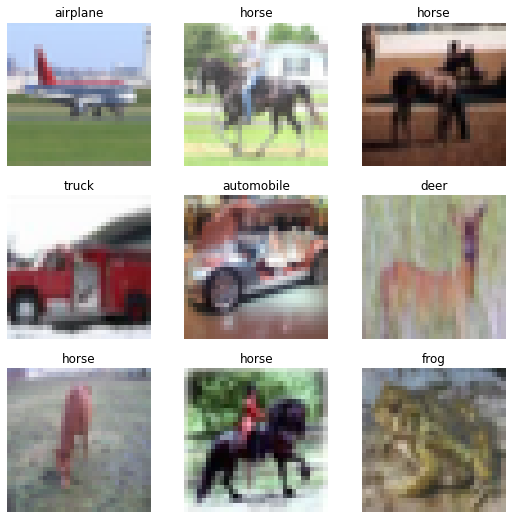

In [22]:
pltsize = 3
row_images = col_images = 3
maxtoshow = row_images * col_images
plt.figure(figsize=(col_images*pltsize,row_images*pltsize))

for i in range(0, maxtoshow):
    i_rand = random.randint(0, x_train.shape[0])
    plt.subplot(row_images,col_images, i + 1)
    plt.axis('off')
    plt.imshow(x_train[i_rand])
    plt.title("{}".format(classes[y_train[i_rand][0]]))

Prepare the data for input to a Feedforward network

In [23]:
print(x_train.shape, 'train samples')
print(x_valid.shape, 'valid samples')
print(x_test.shape, 'test samples')

(35000, 32, 32, 3) train samples
(15000, 32, 32, 3) valid samples
(10000, 32, 32, 3) test samples


In [24]:
# input image dimensions
img_rows, img_cols = 32, 32

In [25]:
# Convert the features and labels to PyTorch tensors
x_train = torch.tensor(x_train).float()
x_valid = torch.tensor(x_valid).float()
x_test = torch.tensor(x_test).float()

In [27]:
y_train = torch.tensor(y_train).long().flatten(start_dim=0)
y_valid = torch.tensor(y_valid).long().flatten(start_dim=0)
y_test = torch.tensor(y_test).long().flatten(start_dim=0)

# Print the shape of y_train, y_valid, y_test
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

y_train shape: torch.Size([35000])
y_valid shape: torch.Size([15000])
y_test shape: torch.Size([10000])


## Build Simple Feedforward Neural Network 

In [28]:
input_features = 3072 # 32*32*3
num_classes = 10

In [29]:
class FeedforwardNeuralNetModel(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(FeedforwardNeuralNetModel, self).__init__()
    # Linear function
    # 3072 --> 500
    self.fc1 = nn.Linear(input_dim, 500) 

    # Linear function (readout)
    # 500 --> 10
    self.fc2 = nn.Linear(500, output_dim)  

  def forward(self, x):
    # Flatten the features from (n, 32, 32, 3) to (n, 3072)
    x = x.flatten(start_dim = 1)

    # Feed to fully-connected layer to predict class
    x = self.fc1(x)

    x = self.fc2(x)

    return x    

In [30]:
# Create an instance of the model class and allocate it to the device
model = FeedforwardNeuralNetModel(input_dim = input_features, output_dim = num_classes)

print(model)     

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=3072, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


## Train the model

In [31]:
# Set the number of epochs to train for
epochs = 20
batch_size = 256
learning_rate = 0.001 

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# Define lists to store the training and validation loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [14]:
# Start training
for epoch in range(epochs):
    # Set the model to train mode
    model.train()

    # Initialize the training loss and accuracy for this epoch
    running_loss = 0.0
    running_corrects = 0

    # Iterate over the training set in batches
    for i in range(0, x_train.shape[0], batch_size):
       
        # Get a batch of features and targets from the training set
        batch_features = x_train[i:i+batch_size]
        batch_targets = y_train[i:i+batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(torch.argmax(outputs, dim=1) == batch_targets)
        
    # Compute statistics for the entire epoch
    epoch_loss = running_loss / len(x_train)
    epoch_acc = running_corrects.item() / len(x_train) * 100

    # Append the training statistics to the lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluation on validation set
    with torch.no_grad():
        val_outputs = model(x_valid)
        val_loss = criterion(val_outputs, y_valid)
        val_corrects = torch.sum(torch.argmax(val_outputs, dim=1) == y_valid)
        val_acc = val_corrects.item() / len(x_valid) * 100

    # Append the validation statistics to the lists
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, \
    Training Loss: {epoch_loss:.4f}, \
    Training Accuracy: {epoch_acc:.2f}%, \
    Validation Loss: {val_loss.item():.4f}, \
    Validation Accuracy: {val_acc:.2f}%')

Epoch 1/20,     Training Loss: 523.2843,     Training Accuracy: 18.55%,     Validation Loss: 215.3817,     Validation Accuracy: 19.93%
Epoch 2/20,     Training Loss: 139.3390,     Training Accuracy: 21.64%,     Validation Loss: 68.1937,     Validation Accuracy: 26.69%
Epoch 3/20,     Training Loss: 54.5212,     Training Accuracy: 25.05%,     Validation Loss: 44.6431,     Validation Accuracy: 21.76%
Epoch 4/20,     Training Loss: 29.2527,     Training Accuracy: 25.89%,     Validation Loss: 8.3304,     Validation Accuracy: 33.76%
Epoch 5/20,     Training Loss: 14.2505,     Training Accuracy: 26.01%,     Validation Loss: 7.3658,     Validation Accuracy: 29.69%
Epoch 6/20,     Training Loss: 7.3025,     Training Accuracy: 26.42%,     Validation Loss: 4.6259,     Validation Accuracy: 29.69%
Epoch 7/20,     Training Loss: 3.1546,     Training Accuracy: 30.66%,     Validation Loss: 2.2135,     Validation Accuracy: 34.81%
Epoch 8/20,     Training Loss: 2.1616,     Training Accuracy: 34.35%,   

In [15]:
print('The average accuracy of validation: ', np.mean(val_accuracies))
print('The max accuracy of validation: ', np.max(val_accuracies), ' at epcoch ', val_accuracies.index(np.max(val_accuracies)))

The average accuracy of validation:  33.094333333333324
The max accuracy of validation:  37.593333333333334  at epcoch  12


Plot accuracy and loss over the training period for training and validation sets.

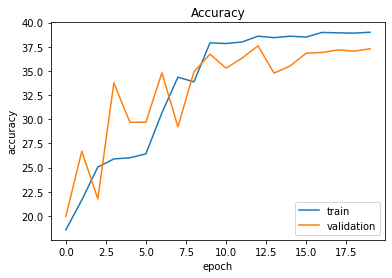

In [16]:
# Summarize history for accuracy
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.ylim((0, 1.1))
plt.show()

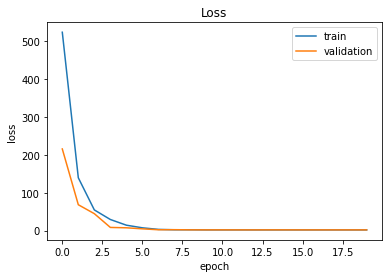

In [17]:
# Summarize history for loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.ylim((-0.1, 1.2))
plt.show()

## Model Evaluation

In [18]:
# Make a set of predictions for the test data
y_pred = model(x_test)
y_pred = torch.argmax(y_pred, dim=1).numpy()

In [20]:
from sklearn import metrics
print("****** Test Data ********")

# Print performance details
print(metrics.classification_report(y_test, y_pred))

****** Test Data ********
              precision    recall  f1-score   support

           0       0.42      0.42      0.42      1000
           1       0.68      0.18      0.28      1000
           2       0.25      0.34      0.29      1000
           3       0.27      0.19      0.22      1000
           4       0.40      0.29      0.33      1000
           5       0.24      0.40      0.30      1000
           6       0.48      0.33      0.39      1000
           7       0.42      0.43      0.42      1000
           8       0.39      0.63      0.48      1000
           9       0.46      0.43      0.44      1000

    accuracy                           0.36     10000
   macro avg       0.40      0.36      0.36     10000
weighted avg       0.40      0.36      0.36     10000



## Different Feedforward Model

Experiment with different feed-forward model sizes and different hyper parameters.

The new feed-forward model has below differences:
* More hidden layers
* Using ReLU activation function 

In [15]:
class FeedforwardNeuralNetModel_2(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(FeedforwardNeuralNetModel_2, self).__init__()

    self.net = nn.Sequential(
      # Linear function
      # 3072 --> 4096
      nn.Linear(input_dim, 4096),  
      nn.ReLU(),
      # 4096 --> 2048
      nn.Linear(4096, 2048),
      nn.ReLU(),
      # 2048 --> 1024
      nn.Linear(2048, 1024),
      nn.ReLU(),
      # 1024 --> 512
      nn.Linear(1024, 512),
      nn.ReLU(),
      # Linear function (readout)
      # 512 --> 10        
      nn.Linear(512, output_dim), 
      #nn.Softmax()
    )

  def forward(self, x):
    # Flatten the features from (n, 32, 32, 3) to (n, 3072)
    x = x.flatten(start_dim = 1)

    return self.net(x)

In [16]:
# Create an instance of the model class and allocate it to the device
model = FeedforwardNeuralNetModel_2(input_dim = input_features, output_dim = num_classes)

print(model) 

FeedforwardNeuralNetModel_2(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)


Train the model

In [32]:
# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# Define lists to store the training and validation loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [33]:
# Start training
for epoch in range(epochs):
    # Set the model to train mode
    model.train()

    # Initialize the training loss and accuracy for this epoch
    running_loss = 0.0
    running_corrects = 0

    # Iterate over the training set in batches
    for i in range(0, x_train.shape[0], batch_size):
       
        # Get a batch of features and targets from the training set
        batch_features = x_train[i:i+batch_size]
        batch_targets = y_train[i:i+batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(torch.argmax(outputs, dim=1) == batch_targets)
        
    # Compute statistics for the entire epoch
    epoch_loss = running_loss / len(x_train)
    epoch_acc = running_corrects.item() / len(x_train) * 100

    # Append the training statistics to the lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluation on validation set
    with torch.no_grad():
        val_outputs = model(x_valid)
        val_loss = criterion(val_outputs, y_valid)
        val_corrects = torch.sum(torch.argmax(val_outputs, dim=1) == y_valid)
        val_acc = val_corrects.item() / len(x_valid) * 100

    # Append the validation statistics to the lists
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, \
    Training Loss: {epoch_loss:.4f}, \
    Training Accuracy: {epoch_acc:.2f}%, \
    Validation Loss: {val_loss.item():.4f}, \
    Validation Accuracy: {val_acc:.2f}%')

Epoch 1/20,     Training Loss: 533.4683,     Training Accuracy: 19.47%,     Validation Loss: 117.5232,     Validation Accuracy: 22.07%
Epoch 2/20,     Training Loss: 136.5710,     Training Accuracy: 21.64%,     Validation Loss: 66.0201,     Validation Accuracy: 23.69%
Epoch 3/20,     Training Loss: 60.6809,     Training Accuracy: 23.95%,     Validation Loss: 44.2164,     Validation Accuracy: 21.74%
Epoch 4/20,     Training Loss: 31.6724,     Training Accuracy: 24.35%,     Validation Loss: 12.5992,     Validation Accuracy: 28.50%
Epoch 5/20,     Training Loss: 15.5656,     Training Accuracy: 24.17%,     Validation Loss: 8.9666,     Validation Accuracy: 24.82%
Epoch 6/20,     Training Loss: 7.1671,     Training Accuracy: 26.49%,     Validation Loss: 5.4272,     Validation Accuracy: 28.31%
Epoch 7/20,     Training Loss: 3.2998,     Training Accuracy: 29.59%,     Validation Loss: 2.7202,     Validation Accuracy: 29.86%
Epoch 8/20,     Training Loss: 2.4325,     Training Accuracy: 32.58%,  

In [34]:
print('The average accuracy of validation: ', np.mean(val_accuracies))
print('The max accuracy of validation: ', np.max(val_accuracies), ' at epcoch ', val_accuracies.index(np.max(val_accuracies)))

The average accuracy of validation:  32.82233333333333
The max accuracy of validation:  37.63333333333333  at epcoch  15


Plot accuracy and loss over the training period for training and validation sets.

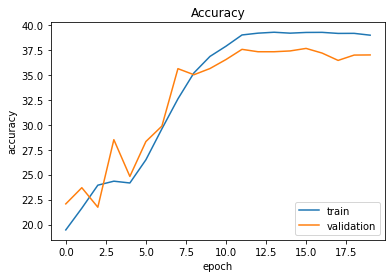

In [35]:
# Summarize history for accuracy
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.ylim((0, 1.1))
plt.show()

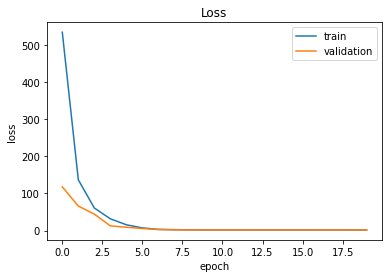

In [36]:
# Summarize history for loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.ylim((-0.1, 1.2))
plt.show()

## Build a Convolutional Network

Set up the convolutional neural network.

In [139]:
class CNN(nn.Module):
    
    # Defining the Constructor
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        
        self.net = nn.Sequential(
          # In the init function, we define the layers will be used in our model        
          # 32 filters applied in the first convolutional layer with a kernel size of 3
          nn.Conv2d(in_channels=3, 
                    out_channels=32, 
                    kernel_size=3, 
                    stride=1, 
                    padding=1),  
          nn.ReLU(),
          nn.Conv2d(in_channels=32, 
                    out_channels=32, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),
          nn.ReLU(),                              
          # Apply max pooling with a kernel size of 2
          nn.MaxPool2d(kernel_size=2),
          nn.Dropout(p=0.2),

          nn.Conv2d(in_channels=32, 
                    out_channels=64, 
                    kernel_size=3, 
                    stride=1, 
                    padding=1),  
          nn.ReLU(),
          nn.Conv2d(in_channels=64, 
                    out_channels=64, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),
          nn.ReLU(),                              
          # Apply max pooling with a kernel size of 2
          nn.MaxPool2d(kernel_size=2),
          nn.Dropout(p=0.2),

          nn.Flatten(1),

          # Our 32x32 image tensors will be pooled twice with a kernel size of 2. therefore, 32/2/2 is 8.
          # This means that the output of the second convolutional layer will be 128x8x8.
          
          # We need to flatten these in order to feed them to a fully-connected layer
          nn.Linear(in_features= 64 * 6 * 6, out_features=512), 
          nn.ReLU(),
          nn.Linear(in_features=512, out_features = num_classes),

          nn.Softmax(dim=1)
        )

    def forward(self, x):        
        return self.net(x)

In [140]:
# Create an instance of the model class and allocate it to the device
model = CNN(num_classes=num_classes)

print(model)

CNN(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=10, bias=True)
    (16): Softmax(dim=1)
  )
)


Reload image dataset

In [118]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                                    random_state=0,
                                    train_size=0.7)
classes = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 
           5:"dog", 6:"frog",7:"horse", 8:"ship", 9:"truck"}

In [119]:
print(x_train.shape, 'train samples')
print(x_valid.shape, 'valid samples')
print(x_test.shape, 'test samples')

(35000, 32, 32, 3) train samples
(15000, 32, 32, 3) valid samples
(10000, 32, 32, 3) test samples


In [120]:
# Reshape the features from (n, 1024) to (n, 1, 32, 32)
x_train = x_train.reshape(-1, 3, img_rows, img_cols)
x_valid = x_valid.reshape(-1, 3, img_rows, img_cols)
x_test = x_test.reshape(-1, 3, img_rows, img_cols)

# Convert the features and labels to PyTorch tensors
x_train = torch.tensor(x_train).float()
x_valid = torch.tensor(x_valid).float()
x_test = torch.tensor(x_test).float()

# Print the shape of x_train, x_valid, x_test
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples', x_train.shape[1], 'features')
print(x_valid.shape[0], 'valid samples', x_valid.shape[1], 'features')
print(x_test.shape[0], 'test samples', x_test.shape[1], 'features')

x_train shape: torch.Size([35000, 3, 32, 32])
35000 train samples 3 features
15000 valid samples 3 features
10000 test samples 3 features


In [121]:
y_train = torch.tensor(y_train).long().flatten(start_dim=0)
y_valid = torch.tensor(y_valid).long().flatten(start_dim=0)
y_test = torch.tensor(y_test).long().flatten(start_dim=0)

# Print the shape of y_train, y_valid, y_test
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

y_train shape: torch.Size([35000])
y_valid shape: torch.Size([15000])
y_test shape: torch.Size([10000])


Train the model

In [141]:
# Set the number of epochs to train for
epochs = 15
batch_size = 100
learning_rate = 0.001

# Loss and optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Define lists to store the training and validation loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [142]:
# Start training
for epoch in range(epochs):
    # Set the model to train mode
    model.train()

    # Initialize the training loss and accuracy for this epoch
    running_loss = 0.0
    running_corrects = 0

    # Iterate over the training set in batches
    for i in range(0, x_train.shape[0], batch_size):
       
        # Get a batch of features and targets from the training set
        batch_features = x_train[i:i+batch_size]
        batch_targets = y_train[i:i+batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(torch.argmax(outputs, dim=1) == batch_targets)
        
    # Compute statistics for the entire epoch
    epoch_loss = running_loss / len(x_train)
    epoch_acc = running_corrects.item() / len(x_train) * 100

    # Append the training statistics to the lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluation on validation set
    with torch.no_grad():
        val_outputs = model(x_valid)
        val_loss = criterion(val_outputs, y_valid)
        val_corrects = torch.sum(torch.argmax(val_outputs, dim=1) == y_valid)
        val_acc = val_corrects.item() / len(x_valid) * 100

    # Append the validation statistics to the lists
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, \
    Training Loss: {epoch_loss:.4f}, \
    Training Accuracy: {epoch_acc:.2f}%, \
    Validation Loss: {val_loss.item():.4f}, \
    Validation Accuracy: {val_acc:.2f}%')

Epoch 1/15,     Training Loss: 2.2463,     Training Accuracy: 19.13%,     Validation Loss: 2.2056,     Validation Accuracy: 23.96%
Epoch 2/15,     Training Loss: 2.1713,     Training Accuracy: 27.81%,     Validation Loss: 2.1437,     Validation Accuracy: 30.69%
Epoch 3/15,     Training Loss: 2.1378,     Training Accuracy: 31.36%,     Validation Loss: 2.1302,     Validation Accuracy: 32.17%
Epoch 4/15,     Training Loss: 2.1113,     Training Accuracy: 34.36%,     Validation Loss: 2.1088,     Validation Accuracy: 34.24%
Epoch 5/15,     Training Loss: 2.0930,     Training Accuracy: 36.31%,     Validation Loss: 2.0920,     Validation Accuracy: 36.25%
Epoch 6/15,     Training Loss: 2.0796,     Training Accuracy: 37.43%,     Validation Loss: 2.0820,     Validation Accuracy: 37.04%
Epoch 7/15,     Training Loss: 2.0680,     Training Accuracy: 38.77%,     Validation Loss: 2.0873,     Validation Accuracy: 36.51%
Epoch 8/15,     Training Loss: 2.0612,     Training Accuracy: 39.59%,     Validatio

In [143]:
print('The average accuracy of validation: ', np.mean(val_accuracies))
print('The max accuracy of validation: ', np.max(val_accuracies), ' at epcoch ', val_accuracies.index(np.max(val_accuracies)))

The average accuracy of validation:  36.288444444444444
The max accuracy of validation:  41.986666666666665  at epcoch  14


Plot accuracy and loss over the training period for training and validation sets.

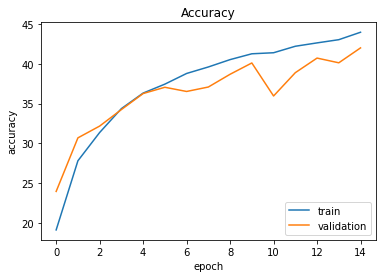

In [144]:
# Summarize history for accuracy
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.ylim((0, 1.1))
plt.show()

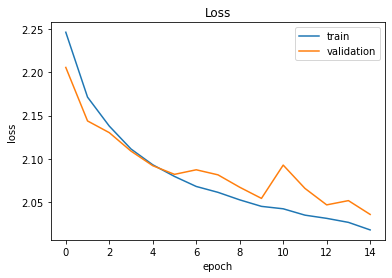

In [145]:
# Summarize history for loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.ylim((-0.1, 1.2))
plt.show()

## Model Evaluation

Evaluate the performance of the convolutional network.

In [146]:
print("****** Test Data ********")

# Make a set of predictions for the test data
y_pred = model(x_test)
y_pred = torch.argmax(y_pred, dim=1).numpy()

# Print performance details
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
display(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

****** Test Data ********
              precision    recall  f1-score   support

           0       0.49      0.39      0.43      1000
           1       0.44      0.60      0.51      1000
           2       0.34      0.32      0.33      1000
           3       0.29      0.31      0.30      1000
           4       0.40      0.28      0.33      1000
           5       0.37      0.31      0.34      1000
           6       0.43      0.49      0.46      1000
           7       0.65      0.32      0.43      1000
           8       0.42      0.69      0.52      1000
           9       0.44      0.44      0.44      1000

    accuracy                           0.41     10000
   macro avg       0.43      0.42      0.41     10000
weighted avg       0.43      0.41      0.41     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,391,65,108,31,24,14,27,15,283,42,1000
1,16,605,4,31,10,15,20,12,135,152,1000
2,92,46,322,119,91,73,115,22,81,39,1000
3,53,62,74,310,44,164,125,25,71,72,1000
4,63,44,157,76,279,72,162,40,85,22,1000
5,21,43,108,240,47,308,100,27,62,44,1000
6,19,66,96,122,63,53,492,7,48,34,1000
7,56,78,56,74,101,95,79,316,52,93,1000
8,65,83,26,33,19,16,7,5,691,55,1000


Compare the feed forward network and the convolutional network. What is the difference kin performance of these two models? What is the difference in the number of trainable weights for these two models?

1. The feed forward network has worse performance than the CNN. And feed forward network did not converage during training, because its loss increased in 20 epoches.
2. The CNN did not reach its best accuracy yet, because the loss plot indicates that loss value is still decreasing.  
3. The feed forward network is much faster than CNN when training on the same size of dataset. 
4. The CNN has much less parameters than the feed forward network. See below calculation results.

In [162]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [163]:
# Print the shape of x_train, x_valid, x_test
print('Total number of CNN parameters', count_parameters(model))

Total number of CNN parameters 1250858


In [164]:
model = FeedforwardNeuralNetModel(input_dim = input_features, output_dim = num_classes)
print('Total number of FeedforwardNeuralNetModel parameters', count_parameters(model))

Total number of FeedforwardNeuralNetModel parameters 1541510


In [165]:
model = FeedforwardNeuralNetModel_2(input_dim = input_features, output_dim = num_classes)
print('Total number of FeedforwardNeuralNetModel_2 parameters', count_parameters(model))

Total number of FeedforwardNeuralNetModel_2 parameters 23605770
